### Minimal Manipulation to Get a Machine Learning Pipeline Running

Notebook inspired by: https://civisanalytics.com/blog/data-science/2015/12/17/workflows-in-python-getting-data-ready-to-build-models/

Data source: https://www.drivendata.org/competitions/7/page/25/

<ol>
<li>Load the features and label data *.csv files as pandas dataframes</li>
<li>Map target label from string to int</li>
<li>steps</li>
</ol>

Load data as dataframes

In [14]:
import pandas as pd
import numpy as np

features_df = pd.DataFrame.from_csv("well_data.csv")   # features data
labels_df   = pd.DataFrame.from_csv("well_labels.csv") # labels
print( labels_df.head(4) )

         status_group
id                   
69572      functional
8776       functional
34310      functional
67743  non functional


There are three target well labels in the data
<ol>
<li>functional</li>
<li>non functional</li>
<li>functional needs repair</li>
</ol>

In [15]:
for x in labels_df['status_group'].unique():  #list all the unique entries of the labels
    print (x)

functional
non functional
functional needs repair


The target variable must be mapped from string labels to integers (a scikit learn requirement), e.g. 'functional' maps to 2 

In [16]:
#function to map the labels from string to ints
#read a string and maps it to one of three integer values 0, 1 & 2
def label_map(y):
   if y=="functional":
       return 2
   elif y=="functional needs repair":
       return 1
   else:
       return 0
labels_df = labels_df.applymap(label_map) # map labels

#test
print( labels_df.head() )

       status_group
id                 
69572             2
8776              2
34310             2
67743             0
19728             2


In [17]:
# Check that the labels have been encoded to ints 0,1,2
for x in labels_df['status_group'].unique():
    print (x)

2
0
1


Check the distribution of the targets - the sub populations are varied

status_group
0    22824
1     4317
2    32259
dtype: int64


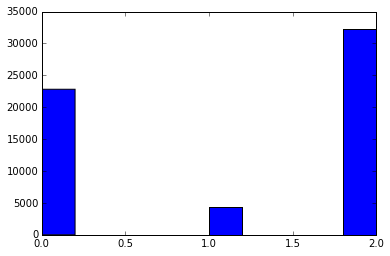

In [22]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.hist(labels_df['status_group'])
print(labels_df.groupby('status_group').size())

Peek at the features data frame, they are a mix of categorical and non categorical data

In [6]:
features_df.head(2)

,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,...,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
id,,,,,,,,,,,,,,,,,,,,,
69572,6000,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,Lake Nyasa,...,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
8776,0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,Lake Victoria,...,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe


There are categorical variables in the dataset but on a first pass, only look at the continous variables

In [24]:
features_df.describe()

,amount_tsh,gps_height,longitude,latitude,num_private,region_code,district_code,population,construction_year
count,59400.000000,59400.000000,59400.000000,5.940000e+04,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000
mean,317.650385,668.297239,34.077427,-5.706033e+00,0.474141,15.297003,5.629747,179.909983,1300.652475
std,2997.574558,693.116350,6.567432,2.946019e+00,12.236230,17.587406,9.633649,471.482176,951.620547
min,0.000000,-90.000000,0.000000,-1.164944e+01,0.000000,1.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,33.090347,-8.540621e+00,0.000000,5.000000,2.000000,0.000000,0.000000
50%,0.000000,369.000000,34.908743,-5.021597e+00,0.000000,12.000000,3.000000,25.000000,1986.000000
75%,20.000000,1319.250000,37.178387,-3.326156e+00,0.000000,17.000000,5.000000,215.000000,2004.000000
max,350000.000000,2770.000000,40.345193,-2.000000e-08,1776.000000,99.000000,80.000000,30500.000000,2013.000000


In [38]:
#features_df.columns.map(lambda x: print(x)) # one way of printing the list of features line by line
#features_df.columns

In [27]:
# Get just the numeric variables by selecting only the variables that are not "object" datatypes.
numeric_variables = list(features_df.dtypes[features_df.dtypes != "object"].index)
features_df[numeric_variables].head()

,amount_tsh,gps_height,longitude,latitude,num_private,region_code,district_code,population,construction_year
id,,,,,,,,,
69572,6000,1390,34.938093,-9.856322,0,11,5,109,1999
8776,0,1399,34.698766,-2.147466,0,20,2,280,2010
34310,25,686,37.460664,-3.821329,0,21,4,250,2009
67743,0,263,38.486161,-11.155298,0,90,63,58,1986
19728,0,0,31.130847,-1.825359,0,18,1,0,0


### Run Bare Metal Random Forest Classifier with Continuous Variables Only

In [41]:
# Continuous Data for bare metal ML
X_numeric = features_df[numeric_variables]
y = labels_df['status_group'].tolist()

In [42]:
import sklearn
clf = sklearn.ensemble.RandomForestClassifier(n_estimators=100, oob_score=True, random_state=42)
score = sklearn.cross_validation.cross_val_score( clf, X_numeric, y )
print( score )

[ 0.71479798  0.7180303   0.70858586]


### Stratified Shuffle Split Sample
Prepare stratified, shuffled and split data for the pipeline

In [57]:
from sklearn.cross_validation import StratifiedShuffleSplit
test_proportion = 0.2 # proportion of data to be held out for testing
seed = 42 # random state seed
numtests = 1 # number of split sets to generate
sss = StratifiedShuffleSplit(y,numtests, test_size=test_proportion, random_state=seed)
for train_index, test_index in sss:
    print("TRAIN indices:", train_index, "TEST indices:", test_index)

TRAIN indices: [56033 42149 50644 ..., 23965 52811 37112] TEST indices: [52237  4107 28169 ..., 54782  2110  3833]


How the train and test data have been split

In [45]:
print(len(train_index))
print(len(test_index))
print(len(train_index) + len(test_index))

47520
11880
59400


Create the stratified training and testing data

In [58]:
X_numeric_train = X_numeric.iloc[train_index,]
X_numeric_test = X_numeric.iloc[test_index,]
y_test = labels_df.iloc[test_index] # iloc does not give those spurious NaNs
y_test = y_test['status_group'].tolist()
y_train = labels_df.iloc[train_index]
y_train = y_train['status_group'].tolist()

### Setup Basic Pipeline

In [52]:
import sklearn.pipeline
steps = [('random_forest', clf)] 
pipeline = sklearn.pipeline.Pipeline(steps) ## Instantiate the pipeline
clf = sklearn.ensemble.RandomForestClassifier()

### Setup Grid Search & Run the Algo

In [56]:
import sklearn.grid_search

parameters = dict(random_forest__min_samples_split=[5, 10], # [2, 3, 4, 5, 10]
              random_forest__min_samples_leaf = [5, 10],
              random_forest__n_estimators = [100, 200]) # the number of trees

cv = sklearn.grid_search.GridSearchCV(pipeline, param_grid=parameters)

cv.fit(X_numeric_train, y_train)
y_predictions = cv.predict(X_numeric_test)
report = sklearn.metrics.classification_report( y_test, y_predictions )
print(report)

             precision    recall  f1-score   support

          0       0.73      0.67      0.70      4565
          1       0.67      0.19      0.30       863
          2       0.73      0.85      0.78      6452

avg / total       0.73      0.73      0.72     11880



With the minimal model completed we can move to model the data with the categorical data included

### xxx

In [8]:
#set(features_df['funder'].tolist()) # to find all the unique entries in a column
## example to show how dictionay is populated
#unique_values = np.array(['zack', 'happy', 'funny', 'panda']).tolist()
#unique_values
#transformer_dict = {}
#for ii, value in enumerate(unique_values):
#    transformer_dict[value] = ii

In [9]:
# This transforms the categorical features into ints
# NOTE: This is NOT one-hot-encoding
def transform_feature( df, column_name ):
    
    unique_values = set( df[column_name].tolist() ) # find unique entries in column
    # init dict & populate dic, assign int to each elem in unique_values
    transformer_dict = {}
    for ii, value in enumerate(unique_values):
        transformer_dict[value] = ii

    def label_map(y):
        return transformer_dict[y]
    df[column_name] = df[column_name].apply( label_map )
    return df

### list of column names indicating which columns to transform; 
### this is just a start!  Use some of the print( labels_df.head() )
### output upstream to help you decide which columns get the
### transformation
names_of_columns_to_transform = ["funder", "installer", "wpt_name", "basin", "subvillage",
                    "region", "lga", "ward", "public_meeting", "recorded_by",
                    "scheme_management", "scheme_name", "permit",
                    "extraction_type", "extraction_type_group",
                    "extraction_type_class",
                    "management", "management_group",
                    "payment", "payment_type",
                    "water_quality", "quality_group", "quantity", "quantity_group",
                    "source", "source_type", "source_class",
                    "waterpoint_type", "waterpoint_type_group"]
for column in names_of_columns_to_transform:
    features_df = transform_feature( features_df, column )
    
print( features_df.head() )

       amount_tsh date_recorded  funder  gps_height  installer  longitude  \
id                                                                          
69572        6000    2011-03-14     842        1390        944  34.938093   
8776            0    2013-03-06    1121        1399        120  34.698766   
34310          25    2013-02-25    1153         686          4  37.460664   
67743           0    2013-01-28    1039         263         82  38.486161   
19728           0    2011-07-13    1247           0       1563  31.130847   

        latitude  wpt_name  num_private  basin          ...            \
id                                                      ...             
69572  -9.856322     34729            0      5          ...             
8776   -2.147466     24432            0      7          ...             
34310  -3.821329      5537            0      0          ...             
67743 -11.155298      5228            0      4          ...             
19728  -1.825359     1

In [10]:
### remove the "date_recorded" column--we're not going to make use
### of time-series data today
features_df.drop("date_recorded", axis=1, inplace=True)

print(features_df.columns.values)

['amount_tsh' 'funder' 'gps_height' 'installer' 'longitude' 'latitude'
 'wpt_name' 'num_private' 'basin' 'subvillage' 'region' 'region_code'
 'district_code' 'lga' 'ward' 'population' 'public_meeting' 'recorded_by'
 'scheme_management' 'scheme_name' 'permit' 'construction_year'
 'extraction_type' 'extraction_type_group' 'extraction_type_class'
 'management' 'management_group' 'payment' 'payment_type' 'water_quality'
 'quality_group' 'quantity' 'quantity_group' 'source' 'source_type'
 'source_class' 'waterpoint_type' 'waterpoint_type_group']


In [11]:
features_df.head(3)

,amount_tsh,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,...,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
id,,,,,,,,,,,,,,,,,,,,,
69572,6000,842,1390,944,34.938093,-9.856322,34729,0,5,2799,...,6,1,4,2,2,6,5,2,1,1
8776,0,1121,1399,120,34.698766,-2.147466,24432,0,7,3155,...,4,1,4,0,0,7,6,1,1,1
34310,25,1153,686,4,37.460664,-3.821329,5537,0,0,19032,...,3,1,4,2,2,5,4,1,3,1


In [12]:
# The features and labels are taken out of their dataframe
# and put into a numpy.ndarray and list, respectively.
X = features_df.as_matrix()
y = labels_df["status_group"].tolist()

In [13]:
# logistic regression
import sklearn.linear_model
import sklearn.cross_validation

clf = sklearn.linear_model.LogisticRegression()
score = sklearn.cross_validation.cross_val_score( clf, X, y )
print( score )


[ 0.64818182  0.64777778  0.64550505]


In [14]:
# random forest
import sklearn.tree
import sklearn.ensemble

clf = sklearn.tree.DecisionTreeClassifier()
score = sklearn.cross_validation.cross_val_score( clf, X, y )
print( score )

[ 0.74323232  0.73651515  0.74090909]


In [15]:
clf = sklearn.ensemble.RandomForestClassifier()
score = sklearn.cross_validation.cross_val_score( clf, X, y )
print( score )

[ 0.78989899  0.78929293  0.78378788]


https://civisanalytics.com/blog/data-science/2015/12/23/workflows-in-python-curating-features-and-thinking-scientifically-about-algorithms/

In [16]:
features_df.payment_type.unique()

array([6, 4, 3, 5, 1, 0, 2])

In [17]:
col = features_df.payment_type.tolist()
col = np.reshape( col, (len(col), 1) )
type(col)
import sklearn.preprocessing
enc = sklearn.preprocessing.OneHotEncoder()
enc.fit(col)

OneHotEncoder(categorical_features='all', dtype=<class 'float'>,
       handle_unknown='error', n_values='auto', sparse=True)

In [18]:
# NOTE: OHE Only takes integers as input
# 'The input to this transformer should be a matrix of integers' - from:
# http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html
# one-hot-encoder function that takes the data frame and the title of a column
# and returns the same data frame but one-hot encoding performed on the indicated feature.
# using the scikit-learn OneHotEncoder object, but pandas also has a function called get_dummies()
#that does effectively the same thing. In fact, I find get_dummies() easier to use in many cases,
#but I still find it worthwhile to see a more “manual” version of the transformation at least once.
import sklearn.preprocessing

def hot_encoder(df, column_name):
    column = df[column_name].tolist()
    column = np.reshape( column, (len(column), 1) )  ### needs to be an N x 1 numpy array
    enc = sklearn.preprocessing.OneHotEncoder()
    enc.fit( column )
    new_column = enc.transform( column ).toarray()
    column_titles = []
    ### making titles for the new columns, and appending them to dataframe
    for ii in range( len(new_column[0]) ):
        this_column_name = column_name+"_"+str(ii)
        df[this_column_name] = new_column[:,ii]
    return df

In [19]:
print(features_df.columns.values)


features_df.drop( "funder", axis=1, inplace=True )
features_df.drop( "installer", axis=1, inplace=True )
features_df.drop( "wpt_name", axis=1, inplace=True )
features_df.drop( "subvillage", axis=1, inplace=True )
features_df.drop( "ward", axis=1, inplace=True )

names_of_columns_to_transform.remove("funder")
names_of_columns_to_transform.remove("installer")
names_of_columns_to_transform.remove("wpt_name")
names_of_columns_to_transform.remove("subvillage")
names_of_columns_to_transform.remove("ward")

# perform OHE for columns of interest that needs to be transformed
for feature in names_of_columns_to_transform:
    features_df = hot_encoder( features_df, feature )

features_df.head()

['amount_tsh' 'funder' 'gps_height' 'installer' 'longitude' 'latitude'
 'wpt_name' 'num_private' 'basin' 'subvillage' 'region' 'region_code'
 'district_code' 'lga' 'ward' 'population' 'public_meeting' 'recorded_by'
 'scheme_management' 'scheme_name' 'permit' 'construction_year'
 'extraction_type' 'extraction_type_group' 'extraction_type_class'
 'management' 'management_group' 'payment' 'payment_type' 'water_quality'
 'quality_group' 'quantity' 'quantity_group' 'source' 'source_type'
 'source_class' 'waterpoint_type' 'waterpoint_type_group']


,amount_tsh,gps_height,longitude,latitude,num_private,basin,region,region_code,district_code,lga,...,waterpoint_type_3,waterpoint_type_4,waterpoint_type_5,waterpoint_type_6,waterpoint_type_group_0,waterpoint_type_group_1,waterpoint_type_group_2,waterpoint_type_group_3,waterpoint_type_group_4,waterpoint_type_group_5
id,,,,,,,,,,,,,,,,,,,,,
69572,6000,1390,34.938093,-9.856322,0,5,17,11,5,94,...,0,0,0,0,0,1,0,0,0,0
8776,0,1399,34.698766,-2.147466,0,7,10,20,2,17,...,0,0,0,0,0,1,0,0,0,0
34310,25,686,37.460664,-3.821329,0,0,1,21,4,75,...,1,0,0,0,0,1,0,0,0,0
67743,0,263,38.486161,-11.155298,0,4,4,90,63,19,...,1,0,0,0,0,1,0,0,0,0
19728,0,0,31.130847,-1.825359,0,7,19,18,1,37,...,0,0,0,0,0,1,0,0,0,0


In [20]:
features_df.shape

(59400, 3031)

In [21]:
X = features_df # update the training data to that that has been OHE
X.shape # note the number of columns representing the number of features!

(59400, 3031)

In [22]:
# select the best features 'or so'
import sklearn.feature_selection

select = sklearn.feature_selection.SelectKBest(k=800)
X = features_df
selected_X = select.fit_transform(X, y)

print( selected_X.shape )

/Users/Izham/apps/miniconda3/lib/python3.4/site-packages/sklearn/feature_selection/univariate_selection.py:111: UserWarning: Features [ 12 191] are constant.
  UserWarning)


(59400, 800)


In [23]:
selected_X0 = select.fit(X, y)

/Users/Izham/apps/miniconda3/lib/python3.4/site-packages/sklearn/feature_selection/univariate_selection.py:111: UserWarning: Features [ 12 191] are constant.
  UserWarning)


In [24]:
# from warning above shows that column 12 and 191 are CONSTANT
# test plot their value 
#X[X.columns[12]]
#X[X.columns[191]]
# NOTE: sklearn.feature_selection

https://civisanalytics.com/blog/data-science/2016/01/06/workflows-python-using-pipeline-gridsearchcv-for-compact-code/

In [25]:
# re-run the random forest with just a X features
clf = sklearn.ensemble.RandomForestClassifier()
score = sklearn.cross_validation.cross_val_score( clf, selected_X, y )
print( score )

[ 0.77762626  0.78409091  0.77686869]


### Pipeline Explanation
- Import pipeline with:
- import sklearn.pipeline
<ol>
<li>Import the required modules including the pipeline module</li>
<li>Instantiate the required modules like select best and random forest classifier etc</li>
<li>Build the steps list of tuples ('customNameOfStep', instantiatedStepVariableName) </li>
<li>Instantiate pipeline </li>
</ol>

In [27]:
# Data setup
X_train, X_test, y_train, y_test = sklearn.cross_validation.train_test_split(X, y, test_size=0.33, random_state=42)

import sklearn.pipeline

# initialize the modules that will be used in the pipeline
# select the minimal k best features
select = sklearn.feature_selection.SelectKBest(k=50)
# initialize classifier
clf = sklearn.ensemble.RandomForestClassifier()

# Build the steps list of tuples ('customNameOfStep', instantiatedStepVariableName)
# Note the customNameOfStep - is a user selected name
# instantiatedStepVariableName - this is the variable name of the instantiated 
steps = [('feature_selection', select),
        ('random_forest', clf)]

# Instantiate the pipeline
pipeline = sklearn.pipeline.Pipeline(steps)

### fit your pipeline on X_train and y_train
pipeline.fit( X_train, y_train )
### call pipeline.predict() on your X_test data to make a set of test predictions
y_prediction = pipeline.predict( X_test )
### test your predictions using sklearn.classification_report()
report = sklearn.metrics.classification_report( y_test, y_prediction )
### and print the report
print(report)

/Users/Izham/apps/miniconda3/lib/python3.4/site-packages/sklearn/feature_selection/univariate_selection.py:111: UserWarning: Features [  12  191  208  227  233  237  241  271  272  280  283  289  294  349  350
  361  387  388  393  394  401  406  411  420  423  425  443  449  452  458
  474  476  495  496  502  512  548  549  555  556  559  561  562  574  577
  588  603  608  616  621  623  634  641  648  655  666  673  678  692  702
  705  719  723  737  740  758  770  777  781  789  797  843  844  845  847
  848  883  884  893  894  900  901  903  904  910  916  944  955  966  968
  975  989 1015 1027 1028 1036 1045 1046 1055 1056 1063 1064 1080 1081 1089
 1099 1118 1124 1133 1135 1159 1163 1164 1174 1178 1182 1184 1202 1209 1228
 1239 1255 1258 1271 1286 1292 1302 1307 1315 1319 1338 1344 1362 1381 1384
 1391 1406 1410 1417 1418 1429 1430 1449 1451 1461 1465 1477 1478 1480 1512
 1515 1524 1534 1539 1545 1546 1547 1552 1558 1559 1578 1584 1597 1600 1607
 1611 1618 1643 1644 1657 1678

             precision    recall  f1-score   support

          0       0.76      0.76      0.76      7458
          1       0.39      0.37      0.38      1425
          2       0.80      0.80      0.80     10719

avg / total       0.75      0.75      0.75     19602



https://civisanalytics.com/blog/data-science/2016/01/06/workflows-python-using-pipeline-gridsearchcv-for-compact-code/

In [28]:
pipeline

Pipeline(steps=[('feature_selection', SelectKBest(k=50, score_func=<function f_classif at 0x10cc2b7b8>)), ('random_forest', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))])

In [29]:
print(report)

             precision    recall  f1-score   support

          0       0.76      0.76      0.76      7458
          1       0.39      0.37      0.38      1425
          2       0.80      0.80      0.80     10719

avg / total       0.75      0.75      0.75     19602



### Stratified Shuffle Split Sample

In [30]:
from sklearn.cross_validation import StratifiedShuffleSplit
sss = StratifiedShuffleSplit(y,2, test_size=0.2, random_state=42)
for train_index, test_index in sss:
    print("TRAIN indices:", train_index, "TEST indices:", test_index)

TRAIN indices: [56033 42149 50644 ..., 23965 52811 37112] TEST indices: [52237  4107 28169 ..., 54782  2110  3833]
TRAIN indices: [31788 54920  3600 ..., 37340 40168 39623] TEST indices: [21495  5759  4607 ..., 28518   447 26835]


In [31]:
X.shape

(59400, 3031)

In [32]:
#X_train = X[train_index]
print(len(train_index))
print(len(test_index))
print(len(train_index) + len(test_index))

47520
11880
59400


In [33]:
X_train = X.iloc[train_index,]
X_test = X.iloc[test_index,]
y_train = labels_df.values[train_index]
y_test = labels_df.values[test_index]
print(X_train.shape)
print(X_test.shape)

(47520, 3031)
(11880, 3031)


In [34]:
type(labels_df)

pandas.core.frame.DataFrame

In [35]:
#y_train = y_train.tolist()
#y_test = y_test.tolist()
#print(len(y_train))
#print(len(y_test))

In [36]:
X_train.dropna().shape

(47520, 3031)

In [37]:
X_test.dropna().shape

(11880, 3031)

In [38]:
len(y_train)

47520

In [39]:
y_test = labels_df.iloc[test_index] # iloc does not give those spurious NaNs
y_test0 = y_test['status_group'].tolist()
print(type(y_test0))
print(len(y_test0))

<class 'list'>
11880


In [40]:
y_train = labels_df.iloc[train_index]
y_train0 = y_train['status_group'].tolist()
print(type(y_train0))
print(len(y_train0))

<class 'list'>
47520


In [41]:
#out = np.concatenate(input_list).ravel().tolist()

In [42]:
# random forest
import sklearn.tree
import sklearn.ensemble

clf = sklearn.tree.DecisionTreeClassifier()
score = sklearn.cross_validation.cross_val_score( clf, X_train, y_train0 )
print( score )

[ 0.74731726  0.75131006  0.75528758]


In [43]:
clf = sklearn.ensemble.RandomForestClassifier()
score = sklearn.cross_validation.cross_val_score( clf, X_train, y_train0 )
print( score )

[ 0.77168287  0.77814256  0.77776375]


In [44]:
import sklearn.grid_search


parameters = dict(feature_selection__k=[100], # could be more [100, 200] 
              #random_forest__n_estimators=[50], # [50, 100, 200] # the number of trees
              random_forest__min_samples_split=[10], # [2, 3, 4, 5, 10]
              random_forest__min_samples_leaf = [5, 10],
              random_forest__n_estimators = [10, 20])

cv = sklearn.grid_search.GridSearchCV(pipeline, param_grid=parameters)

cv.fit(X_train, y_train0)
y_predictions = cv.predict(X_test)
report = sklearn.metrics.classification_report( y_test0, y_predictions )

/Users/Izham/apps/miniconda3/lib/python3.4/site-packages/sklearn/feature_selection/univariate_selection.py:111: UserWarning: Features [  12  191  204  208  209  227  230  233  237  238  242  250  254  257  268
  272  273  280  289  304  309  338  349  362  371  375  376  380  383  389
  392  394  402  406  408  415  416  418  420  436  437  452  454  455  460
  467  486  491  496  497  505  507  516  518  528  545  549  555  561  563
  574  577  578  587  588  589  594  596  604  608  610  611  616  621  634
  641  647  649  660  661  675  677  688  692  698  701  702  707  709  712
  714  718  723  724  740  754  755  775  779  780  781  783  789  797  810
  812  825  830  849  852  857  865  867  872  878  884  893  897  898  900
  915  916  924  925  928  944  960  965  966  972  977  984  987  989  992
  994 1003 1011 1013 1028 1036 1046 1052 1055 1056 1063 1064 1065 1067 1073
 1081 1082 1083 1087 1089 1097 1099 1123 1135 1136 1138 1150 1151 1155 1159
 1163 1167 1171 1174 1176 1179

In [45]:
print(report)

             precision    recall  f1-score   support

          0       0.82      0.71      0.76      4565
          1       0.63      0.17      0.27       863
          2       0.76      0.91      0.83      6452

avg / total       0.78      0.78      0.76     11880

